This is the overall code to:
    1) Take the broadband r image, convert to nanomaggies and AB mags
    2) Add in background
    3) Produce an error image according to Poisson statistics (+ background + readnoise)
    4) Produce an error spectrum according to the same statistics (at each wavelength)
    5) Prepare to entre into ppxf according to the MaNGA specs

In [22]:
import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches
from astropy.io import fits


from astropy.cosmology import WMAP9 as cosmo

import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches

import sys 

import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp
from scipy.ndimage import iterate_structure

sys.path.append('/usr/local/lib/python2.7/site-packages/ppxf')
sys.path

from __future__ import print_function

from astropy.io import fits
import numpy as np
import glob
from time import clock
from os import path

from ppxf import ppxf
import ppxf_util as util
plt.clf()

from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

import scipy.ndimage.filters as filters
from scipy import ndimage
from scipy.stats import norm

#os.chdir(os.path.expanduser('~/Documents/LAURA_SIMS'))

import photutils
import os



In [ ]:
'''Now I would really love to iterate for all possible viewing angles 0-6'''
img_list=['q0.5_fg0.3_allrx10/broadband_020.fits','q0.5_fg0.3_allrx10/broadband_040.fits',
         'q0.5_fg0.3_allrx10/broadband_070.fits','q0.5_fg0.3_allrx10/broadband_160.fits',
         'q0.5_fg0.3_allrx10/broadband_200.fits','q0.5_fg0.3_allrx10/broadband_210.fits',
         'q0.5_fg0.3_allrx10/broadband_230.fits']
myr=[20,40,70,160,200,210,230]
viewpts=[0,1,2,3,4,5,6]
plott='no'
os.chdir(os.path.expanduser('/Volumes/My Passport for Mac/LAURA_Sims/'))


sep=np.zeros((len(viewpts),len(myr)))
flux_r=np.zeros((len(viewpts),len(myr)))
myr_here=np.zeros((len(viewpts),len(myr)))

gini=np.zeros((len(viewpts),len(myr)))
m20=np.zeros((len(viewpts),len(myr)))
Assy=np.zeros((len(viewpts),len(myr)))
Clump=np.zeros((len(viewpts),len(myr)))
Con=np.zeros((len(viewpts),len(myr)))
plt_label=np.zeros((len(viewpts),len(myr)))
n_bulges=np.zeros((len(viewpts),len(myr)))
viewpts_here=np.zeros((len(viewpts),len(myr)))
    
for k in range(len(viewpts)):
    viewpt=viewpts[k]
    
   
    

    
    for i in range(len(img_list)):#len(img_list)
        viewpts_here[k,i]=viewpt
        plt.clf()
        '''before any of this you have to choose the camera data'''
        a=produce_camera(myr[i],img_list[i],viewpt)#that last number is the viewpoing (camera 0)
        '''a output is actually surface brightness'''
        '''now you need to chop it down to the snapshot of SDSS imaging'''




        b=determine_coords(a[1][2], plott)#was c, taking the second dimension

        low_pass=b[4]
        num_sol=b[5]



        if num_sol==1:
            #this is if there's only really one solution because the bulges are too close together
            c=fit_2_gaussian(b[1],300-b[0],b[1],300-b[0],low_pass, plott)
        else:
            c=fit_2_gaussian(b[2],300-b[0],b[3],300-b[1],low_pass, plott)#was d[3],300-d[2],d[1],300-d[0]



        if c[4] > c[5]:
            '''this means point 1 is brighter'''
            in_x = c[1]
            in_y = c[0]
            in_2_x = c[3]
            in_2_y = c[2]

            reff_1=c[6]
            reff_2=c[7]

        if c[5] > c[4]:
            '''point 2 is the brighter source'''
            in_x = c[3]
            in_y = c[2]
            in_2_x = c[1]
            in_2_y = c[0]

            reff_1=c[7]
            reff_2=c[6]

        

        '''Now we need to clip this so that its the size of an SDSS image'''
        d=clip_image(a[1][2], a[0], 0.03, 300-in_x, in_y)

        '''d output is surface brightness in W/m/m^2/sr but cut'''
        #a[0] is pixelscale

        e=nanomags(0.03, a[0], d[0],viewpt, myr[i])#was a[1]
        texp=1
        prep=convolve_image(myr[i],e[0],e[1],e[2],0.03,a[0],viewpt, e[3], e[4], e[5], texp)
        '''Input to galfit needs to be nanomags'''

        length_gal=shape(d[0])[0]
        
        '''So you need to guess mag correctly mag = −2.5log10(ADUs/texp) + mag zpt.'''
        '''(mag zpt = 26.563)'''
        mag_zpt=26.563
        max_counts=np.max(np.array(prep[3]))
        mag_guess=-2.5*math.log10(max_counts/texp) + mag_zpt

        #abs(xcen2-xcen) < length_gal/2 and abs(ycen2-ycen)/2 < length_gal

        '''Find out how many bulges'''
        if abs(in_x-in_2_x) < length_gal/2 and abs(in_y-in_2_y) < length_gal/2 and in_y != in_2_y and in_x != in_2_x: 
            num_bulges=2
        else:
            num_bulges=1

        n_bulges[k,i]=num_bulges

        plt.clf()
        plt.imshow((prep[3]),norm=matplotlib.colors.LogNorm())
        plt.title('Feeding Galfit')
        plt.colorbar(label='Counts')
        #x_1-xcen+half_pixels
        plt.scatter(length_gal/2,length_gal/2, color='red')
        plt.scatter(length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x), color='red')
        plt.xlim([0,length_gal])
        plt.ylim([0,length_gal])
        plt.show()

        f=write_galfit_feedme(viewpt,myr[i], length_gal/2,length_gal/2,length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x),  mag_guess, mag_zpt, num_bulges, length_gal, reff_1, reff_2)#was 300-in_x






        
        g=run_galfit(viewpt,myr[i])
        
        output='GALFIT_folder/out_'+str(viewpt)+'_'+str(myr[i])+'.fits'
        out=pyfits.open(output)
        try:
            PA1=float(out[2].header['1_PA'][:7])
            PA2=PA1
            AR1=float(out[2].header['1_AR'][:7])
            h=galfit_params(viewpt,myr[i],num_bulges)

            sep[k,i]=(h[0])
            flux_r[k,i]=(h[1])
            myr_here[k,i]=(myr[i])



            PA1=h[2]
            PA2=h[3]
            posx_1=h[4]
            posy_1=h[5]
            posx_2=h[6]
            posy_2=h[7]
            AR_1=h[8]
            gal_out=h[9]

        except ValueError:
            try:
                f=write_galfit_feedme_prev(viewpt,myr[i], length_gal/2,length_gal/2,length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x),  mag_guess, mag_zpt, num_bulges, length_gal, reff_1, reff_2,viewpt,myr[i-1])#was 300-in_x
                
                g=run_galfit(viewpt,myr[i])
                h=galfit_params(viewpt,myr[i],num_bulges)
                
                sep[k,i]=(h[0])
                flux_r[k,i]=(h[1])
                myr_here[k,i]=(myr[i])



                PA1=h[2]
                PA2=h[3]
                posx_1=h[4]
                posy_1=h[5]
                posx_2=h[6]
                posy_2=h[7]
                AR_1=h[8]
                gal_out=h[9]
            except ValueError or FileNotFoundError:
                try:
                    f=write_galfit_feedme_prev(viewpt,myr[i], length_gal/2,length_gal/2,length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x),  mag_guess, mag_zpt, num_bulges, length_gal, reff_1, reff_2,viewpt,myr[i+1])#was 300-in_x
                    
                    g=run_galfit(viewpt,myr[i])
                    h=galfit_params(viewpt,myr[i],num_bulges)
                    
                    sep[k,i]=(h[0])
                    flux_r[k,i]=(h[1])
                    myr_here[k,i]=(myr[i])



                    PA1=h[2]
                    PA2=h[3]
                    posx_1=h[4]
                    posy_1=h[5]
                    posx_2=h[6]
                    posy_2=h[7]
                    AR_1=h[8]
                    gal_out=h[9]
                except ValueError or FileNotFoundError:
                    try:
                        f=write_galfit_feedme_prev(viewpt,myr[i], length_gal/2,length_gal/2,length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x),  mag_guess, mag_zpt, num_bulges, length_gal, reff_1, reff_2,viewpts[k-1],myr[i])#was 300-in_x
                        
                        g=run_galfit(viewpt,myr[i])
                        h=galfit_params(viewpt,myr[i],num_bulges)
                        
                        sep[k,i]=(h[0])
                        flux_r[k,i]=(h[1])
                        myr_here[k,i]=(myr[i])



                        PA1=h[2]
                        PA2=h[3]
                        posx_1=h[4]
                        posy_1=h[5]
                        posx_2=h[6]
                        posy_2=h[7]
                        AR_1=h[8]
                        gal_out=h[9]
                    except ValueError or FileNotFoundError:
                        print('nothing fit')
                        sep[k,i]=999
                        flux_r[k,i]=999
                        myr_here[k,i]=999
            


        
            
        


        ii=calculate_petrosian_radius(d[0], PA1, AR_1, a[0])

        '''Now we need to apply the segmentation mask to the normal surface brightness'''
        mask_sb=ma.masked_where(ii[0] ==0, d[0])



        j=gini_m20(myr[i],np.flipud(mask_sb),viewpt, d[1])#was result_nano

        gini[k,i]=(j[0])
        m20[k,i]=(j[1])
        plt_label[k,i]=(str(myr[i]))





        '''What if I want to actually do the diagnostic from someone where you get to flip an image around?'''


        mask_result=ma.masked_where(ii[0]==0, np.flipud(prep[0]))
        mask_result_bg=ma.masked_where(ii[0]==0, np.flipud(prep[1]))

        gg=img_assy(np.flipud(prep[0]), np.flipud(prep[1]), in_x, in_y, viewpt, myr[i], plott, ii[4])




        kk=measure_concentration(ii[4], np.flipud(prep[0]))
        #input: petrosian radius






        l = clumpiness(np.flipud(prep[0]), np.flipud(prep[1]), ii[4])



        Assy[k,i]=(gg[0])
        Clump[k,i]=(l[0])
        Con[k,i]=(kk[0])



    




In [27]:
viewpts=[0,1,2,3,4,5,6]
myr=[20,40,70,160,200,210,230]
'''Viewpoints, then myr'''
#sep[k,i]=(h[0])
#flux_r[k,i]=(h[1])
#myr_here[k,i]=(myr[i])
#Assy[k,i]=(gg[0])
#Clump[k,i]=(l[0])
#Con[k,i]=(kk[0])
#n_bulges[k,i]
print(viewpts_here)
print(myr_here)
print(flux_r)
print(n_bulges)

#if abs(Assy[i]) > 0.35 and Clump[i] > 0.35:

[[  20.   40.   70.  160.  200.  210.  230.]
 [  20.   40.   70.  160.  200.  210.  230.]
 [  20.   40.   70.  160.  200.  210.  230.]
 [  20.   40.   70.  160.  200.  210.  230.]
 [  20.   40.   70.  160.  200.  210.  230.]
 [  20.   40.   70.  160.  200.  210.  230.]
 [   0.   40.   70.  160.  200.  210.  230.]]
[[  0.00000000e+00   2.28960202e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   2.28559880e-02   2.95828492e+00]
 [  0.00000000e+00   9.48331115e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   2.15417013e-01   1.42049595e+00]
 [  0.00000000e+00   1.46163859e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   5.27910135e+00   1.09405713e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    4.19218076e+00   1.65135331e-01   4.15068715e-01]
 [  0.00000000e+00   3.59054191e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   6.42332653e+00   7.44663385e-01]
 [  0.00000000e+00   2.78278722e+00   0.00000000e+00   0.0000000

In [184]:

Con=Con.flatten()
Assy=Assy.flatten()
Clump=Clump.flatten()
print(Con)
colors=[]
for i in range(len(Con)):
    if abs(Assy[i]) > 0.35 and Clump[i] > 0.35:
        colors.append('Orange')
    else:
        colors.append('Black')
print('colors', colors)
plt.clf()
plt.scatter(Con, (Assy), color=colors)
plt.ylabel('A(R)')
plt.xlabel('C(R)')
plt.ylim([1,-0.2])
plt.xlim([5.2,1.8])
plt.axhline(y=0.35)
plt.annotate("", xy=(5, 0.45), xytext=(5, 0.37),
    arrowprops=dict(arrowstyle="->"))
savefig('../MaNGA_Papers/Paper_I/CA_all.pdf')

plt.clf()
plt.scatter(Clump, Assy, color=colors, marker='*')
plt.scatter(Clump[0], Assy[0], color=colors[0],label='Non Merger', marker='*')
plt.scatter(Clump[1], Assy[1], color=colors[1],label='Merger', marker='*')
plt.ylabel('A(R)')
plt.xlabel('S(R)')
plt.axhline(y=0.35, color='black', ls='--')
plt.axvline(x=0.35, color='black', ls='--')
plt.ylim([1,-0.2])
plt.xlim([-0.2,1])
plt.annotate("", xy=(0.95, 0.45), xytext=(0.95, 0.35),
    arrowprops=dict(arrowstyle="->"), size=20)
plt.annotate("", xy=(0.42, 0.9), xytext=(0.35, 0.9),
    arrowprops=dict(arrowstyle="->"), size=20)
plt.tight_layout()
plt.legend()
savefig('../MaNGA_Papers/Paper_I/SA_all.pdf')

plt.clf()
plt.scatter(Con,Clump, color=colors)
plt.ylabel('S(R)')
plt.xlabel('C(R)')
plt.axhline(y=0.35)
plt.ylim([1,-0.2])
plt.xlim([5.2,1.8])
plt.annotate("", xy=(5, 0.49), xytext=(5, 0.42),
    arrowprops=dict(arrowstyle="->"))
savefig('../MaNGA_Papers/Paper_I/CS_all.pdf')


'''Now plot Gini-M20'''
E_S0_gini=[0.62,0.62,0.63,0.62,0.6,0.63,0.6, 
          0.61,0.6,0.56,0.57,0.57,0.58,0.6,0.58,0.56,0.65,0.6,0.63]
E_S0_M20=[-2.45,-2.58,-2.54,-2.58,-2.56,-2.66,-2.60,
         -2.36,02.48,-2.33,-2.40,-2.5,-2.52,-2.37,-2.22,-2.57,-2.69,-2.69,-2.86]

Sa_Sbc_gini=[0.57,0.59,0.61,0.59,0.55,0.55,0.62,0.6,0.48,0.53,0.56,0.52,0.53,0.55]
Sa_Sbc_M20=[-2.2,-2.32,-2.52,-2.6,-2.19,-1.97,-1.27,-2.24,-1.73,-2.09,
           -2.06,-1.53,-1.84,-1.69]

Sc_gini=[0.5,0.44,0.5,0.48,0.47,0.51,0.52,0.58,0.52,0.49,0.53,0.55,0.55,
        0.47,0.42,0.47,0.52,0.58,0.57,0.47,0.5]
Sc_M20=[-1.63,-1.38,-1.41,-1.58,-1,-1.32,-1.64,-2.1,-1.76,-1.43,-1.46,-1.86,
       -1.64,-1.52,-1.34,-1.5,-1.84,-1.61,-1.75,-1.45,-1.82]
m20=m20.flatten()
gini=gini.flatten()
plt_label=plt_label.flatten()


dashed_line_x=np.linspace(-0.5,-3,100)
dashed_line_y=[-0.115*x + 0.384 for x in dashed_line_x]

plt.clf()
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(dashed_line_x, dashed_line_y, ls='--', color='black')

merger_g=[]
merger_m20=[]
non_merger_g=[]
non_merger_m20=[]

for i in range(len(gini)):
    if (-0.115*m20[i]+0.384 > gini[i]):#this means the line is above them so not merger
        non_merger_g.append(gini[i])
        non_merger_m20.append(m20[i])
    else:
        merger_g.append(gini[i])
        merger_m20.append(m20[i])
        print(i)
ax1.scatter(merger_m20, merger_g,label='Merger', marker='*', s=55, color='orange')
ax1.scatter(non_merger_m20, non_merger_g,label='Non Merger', marker='*', s=55, color='black')#label=plt_label[i]
ax1.scatter(E_S0_M20, E_S0_gini, label='E/S0 Lotz et al. 2004',edgecolor='red', s=15)
ax1.scatter(Sa_Sbc_M20, Sa_Sbc_gini, label='Sa-Sbc Lotz et al. 2004',marker='^',edgecolor='green', s=15)
ax1.scatter(Sc_M20, Sc_gini, label='Sc-Sd Lotz et al. 2004',marker='x',color='blue', s=15)


ax1.set_xlim([0,-3])
ax1.set_ylim([0.3,0.8])
ax1.set_xlabel(r'M$_{20}$')
ax1.set_ylabel(r'G')
ax1.set_aspect(abs(3)/abs(0.8-0.3))
#plt.axis('equal')

ax1.legend(loc='upper center',
          ncol=2)
#ax1.set_aspect('equal')
plt.tight_layout()
savefig('../MaNGA_Papers/Paper_I/gini_m20_all.pdf')



[ 2.61439373  3.09894379  4.14651886  4.17316303  3.49485002  3.22547312
  3.89075625  2.7440724   3.21726338  3.72363747  4.10592941  5.33473395
  3.49485002  4.14651886  3.09894379  2.62984911  3.67976785  3.75061263
  3.78973932  3.30590722  4.2254902   2.54652969  2.66801305  4.17316303
  4.51544993  3.26606257  3.70181345  4.68926047  2.61439373  2.72034022
  4.1195437   4.2254902   3.92664918  3.62137935  3.85426006  2.64754662
  2.88618204  3.63499364  3.58927674  4.58226974  3.20965752  3.49485002
  3.01029996  3.01029996  3.89075625  3.84503935  4.04932832  3.16011607
  4.1195437 ]
colors ['Black', 'Orange', 'Orange', 'Orange', 'Black', 'Orange', 'Orange', 'Black', 'Orange', 'Orange', 'Black', 'Orange', 'Black', 'Orange', 'Orange', 'Orange', 'Orange', 'Orange', 'Orange', 'Orange', 'Orange', 'Black', 'Orange', 'Orange', 'Orange', 'Orange', 'Orange', 'Black', 'Black', 'Orange', 'Orange', 'Orange', 'Black', 'Orange', 'Orange', 'Black', 'Orange', 'Black', 'Orange', 'Orange', 'Oran

In [104]:
file_path='GALFIT_folder/galfit.feedme_0_200'

file_path_new=''
    
f = open(file_path, 'r+')
data=f.readlines()

for line in data:
    words = line.split()

    
    if words[0]=='B)':
        print(words)
        print(words[1])
        f.write('Fuck')



    
'''data = f.readlines()


    for line in data:
        words = line.split()
        
        #print(words[0])
        if words[0]=='B)':
            print(words)
            print(words[1])
            file_path.write('Fuck')'''
'''now you need to replace this'''
        
file_path.close()      
stop

['===============================================================================']
['#', 'IMAGE', 'and', 'GALFIT', 'CONTROL', 'PARAMETERS']
['A)', 'out_convolved_0_200.fits', '#', 'Input', 'data', 'image', '(FITS', 'file)']
['B)', 'out_0_200.fits', '#', 'Output', 'data', 'image', 'block']
['B)', 'out_0_200.fits', '#', 'Output', 'data', 'image', 'block']
out_0_200.fits
['C)', 'out_sigma_convolved_0_200.fits', '#', 'Sigma', 'image', 'name', '(made', 'from', 'data', 'i$']
['D)', 'none', '#', '#', 'Input', 'PSF', 'image', 'and', '(optional)', 'diffusion', 'kernel']
['E)', 'none', '#', 'PSF', 'fine', 'sampling', 'factor', 'relative', 'to', 'data']
['F)', 'none', '#', 'Bad', 'pixel', 'mask', '(FITS', 'image', 'or', 'ASCII', 'coord', 'list)']
['G)', 'none', '#', 'File', 'with', 'parameter', 'constraints', '(ASCII', 'file)']
['H)', '1', '182', '1', '182', '#', 'Image', 'region', 'to', 'fit', '(xmin', 'xmax', 'ymin', 'ymax)']
['I)', '182', '182', '#', 'Size', 'of', 'the', 'convolution', 'box',

AttributeError: 'str' object has no attribute 'close'

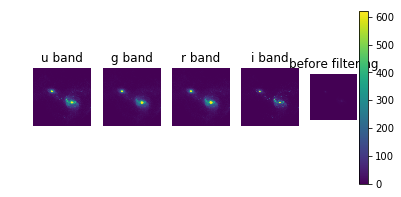

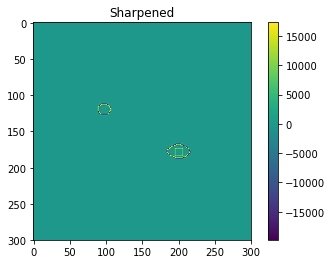

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


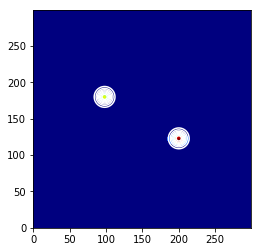

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.


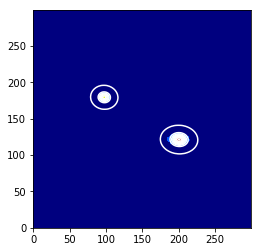

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


reff 7.66731656791 6.03662019874 is this in pixels?
in_x 178.671676661 in_y 200.420350362
info ins[xcen-num_pix_half:xcen+num_pix_half,ycen-num_pix_half:ycen+num_pix_half]
87.6716766606 269.671676661 109.420350362 291.420350362
length 182
num of bulges 1


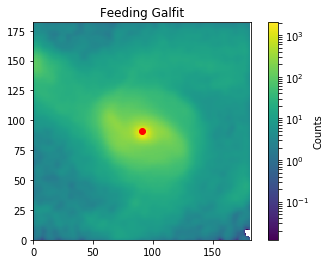

mag_guess 22.624804624161087


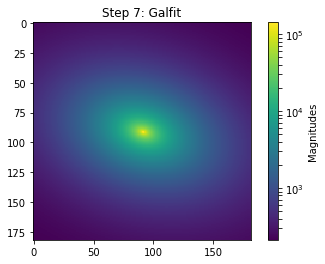

Sersic indices 2.2556 +/- 0.0102
Effective Radius in pixels 30.6332 +/- 0.2133
magnitudes 7.2780 +/- 0.0060
PAs -73.4940 +/- 0.2241
cwd /Volumes/My Passport for Mac/LAURA_Sims
Chi^2 5.500549

/Users/beckynevin/anaconda/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
Exception ignored in: 'photutils.geometry.core.area_arc'
ZeroDivisionError: float division
/Users/beckynevin/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


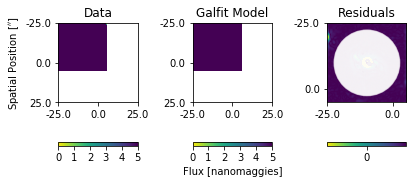

In [168]:
img_list=['q0.5_fg0.3_allrx10/broadband_020.fits','q0.5_fg0.3_allrx10/broadband_040.fits',
         'q0.5_fg0.3_allrx10/broadband_070.fits','q0.5_fg0.3_allrx10/broadband_160.fits',
         'q0.5_fg0.3_allrx10/broadband_200.fits','q0.5_fg0.3_allrx10/broadband_210.fits',
         'q0.5_fg0.3_allrx10/broadband_230.fits']

img_list=['q0.5_fg0.3_allrx10/broadband_200.fits']
myr=[200]
#myr=[200]
sep=[]
flux_r=[]
myr_here=[]
image=[]
gini=[]
m20=[]
Assy=[]
Clump=[]
Con=[]
plt_label=[]
viewpt=0

plott='yes'
os.chdir(os.path.expanduser('/Volumes/My Passport for Mac/LAURA_Sims/'))
for i in range(len(img_list)):#len(img_list)
    plt.clf()
    '''before any of this you have to choose the camera data'''
    a=produce_camera(myr[i],img_list[i],viewpt)#that last number is the viewpoing (camera 0)
    '''a output is actually surface brightness'''
    '''now you need to chop it down to the snapshot of SDSS imaging'''
    
    
    
    
    b=determine_coords(a[1][2], plott)#was c, taking the second dimension
    
    low_pass=b[4]
    num_sol=b[5]
    
    
    
    if num_sol==1:
        #this is if there's only really one solution because the bulges are too close together
        c=fit_2_gaussian(b[1],300-b[0],b[1],300-b[0],low_pass, plott)
    else:
        c=fit_2_gaussian(b[2],300-b[0],b[3],300-b[1],low_pass, plott)#was d[3],300-d[2],d[1],300-d[0]

    
    
    if c[4] > c[5]:
        '''this means point 1 is brighter'''
        in_x = c[1]
        in_y = c[0]
        in_2_x = c[3]
        in_2_y = c[2]
        
        reff_1=c[6]
        reff_2=c[7]
        
    if c[5] > c[4]:
        '''point 2 is the brighter source'''
        in_x = c[3]
        in_y = c[2]
        in_2_x = c[1]
        in_2_y = c[0]
        
        reff_1=c[7]
        reff_2=c[6]
        
    print('reff', reff_1, reff_2, 'is this in pixels?')
    
    print('in_x', 300-in_x, 'in_y', in_y)
    
    '''Now we need to clip this so that its the size of an SDSS image'''
    d=clip_image(a[1][2], a[0], 0.03, 300-in_x, in_y)
    
    '''d output is surface brightness in W/m/m^2/sr but cut'''
    #a[0] is pixelscale
    
    e=nanomags(0.03, a[0], d[0],viewpt, myr[i])#was a[1]
    texp=53.9
    prep=convolve_image(myr[i],e[0],e[1],e[2],0.03,a[0],viewpt, e[3], e[4], e[5], texp)
    '''Input to galfit needs to be nanomags'''
    
    length_gal=shape(d[0])[0]
    print('length', length_gal)
    '''So you need to guess mag correctly mag = −2.5log10(ADUs/texp) + mag zpt.'''
    '''(mag zpt = 26.563)'''
    mag_zpt=26.563
    max_counts=np.max(np.array(prep[3]))
    mag_guess=-2.5*math.log10(max_counts/texp) + mag_zpt
    
    #abs(xcen2-xcen) < length_gal/2 and abs(ycen2-ycen)/2 < length_gal
    
    '''Find out how many bulges'''
    if abs(in_x-in_2_x) < length_gal/2 and abs(in_y-in_2_y) < length_gal/2 and in_y != in_2_y and in_x != in_2_x: 
        num_bulges=2
    else:
        num_bulges=1
        
    print('num of bulges', num_bulges)
    
    
    plt.clf()
    plt.imshow((prep[3]),norm=matplotlib.colors.LogNorm())
    plt.title('Feeding Galfit')
    plt.colorbar(label='Counts')
    #x_1-xcen+half_pixels
    plt.scatter(length_gal/2,length_gal/2, color='red')
    plt.scatter(length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x), color='red')
    plt.xlim([0,length_gal])
    plt.ylim([0,length_gal])
    plt.show()

    f=write_galfit_feedme(viewpt,myr[i], length_gal/2,length_gal/2,length_gal/2+(in_2_y-in_y), length_gal/2-(in_2_x-in_x),  mag_guess, mag_zpt, num_bulges, length_gal, reff_1, reff_2)#was 300-in_x
    

    
    
    
    
    #write_galfit_feedme(view,number,xcen,ycen,xcen2,xcen1, mag, mag_zpt, length_gal):
    print('mag_guess', mag_guess)
    
    
    g=run_galfit(viewpt,myr[i])
    
    
    h=galfit_params(viewpt,myr[i],num_bulges)
    
    
    
    
    sep.append(h[0])
    flux_r.append(h[1])
    myr_here.append(myr[i])
    
    
    
    PA1=h[2]
    PA2=h[3]
    posx_1=h[4]
    posy_1=h[5]
    posx_2=h[6]
    posy_2=h[7]
    AR_1=h[8]
    gal_out=h[9]
  
    
    ii=calculate_petrosian_radius(d[0], PA1, AR_1, a[0])
    
    '''Now we need to apply the segmentation mask to the normal surface brightness'''
    mask_sb=ma.masked_where(ii[0] ==0, d[0])
    
    
   
    j=gini_m20(myr[i],np.flipud(mask_sb),viewpt, d[1])#was result_nano
    
    gini.append(j[0])
    m20.append(j[1])
    plt_label.append(str(myr[i]))
    
    
  
    
    
    '''What if I want to actually do the diagnostic from someone where you get to flip an image around?'''
    
    
    mask_result=ma.masked_where(ii[0]==0, np.flipud(prep[0]))
    mask_result_bg=ma.masked_where(ii[0]==0, np.flipud(prep[1]))
    
    gg=img_assy(np.flipud(prep[0]), np.flipud(prep[1]), in_x, in_y, viewpt, myr[i], plott, ii[4])
    
    
    
    
    k=measure_concentration(ii[4], np.flipud(prep[0]))
    #input: petrosian radius
    
    
    
    
    
    
    l = clumpiness(np.flipud(prep[0]), np.flipud(prep[1]), ii[4])
    
    plt.clf()
    plt.imshow(l[1])
    plt.show()
    
    Assy.append(gg[0])
    Clump.append(l[0])
    Con.append(k[0])
    
    
    
    



In [94]:
print(Clump)
print(Assy)

[-0.74437647541067598, -0.58607314230419116, -0.29015632262094476, -0.69897110926473105, -0.49957410710096783, -0.49695638311359208, -0.51169446169623678]
[-1.1130517090978169, -0.429313429904429, -0.56343892032071274, -0.80792682288223217, -0.71617313162003338, -0.93517156656754086, -0.55969026223001295]


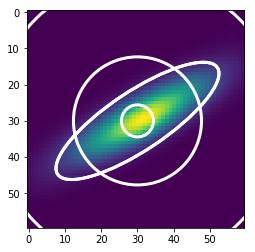

In [190]:
from matplotlib.animation import FuncAnimation
FFwriter = matplotlib.animation.FFMpegWriter(fps=0.5, extra_args=['-vcodec', 'libx264'])


fig, ax = plt.subplots()

ax.imshow(np.flipud(ii[1]))
ii[3].plot(lw=3, color='white')
gg[2].plot(lw=3, color='white')
k[1].plot(lw=3, color='white')
k[2].plot(lw=3, color='white')



plt.show()


plt.clf()
fig, ax = plt.subplots()
fig.set_tight_layout(True)
#div = make_axes_locatable(ax)
#cax = div.append_axes('right', '5%', '5%')

pics=[a[1][2],low_pass,low_pass,d[0],e[0], np.flipud(e[1]), np.flipud(prep[0]), gal_out, ii[1], 
      mask_result, mask_result,gg[1], np.flipud(prep[0]), l[1]]
lim=[[0,300],[0,300],[0,300],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60],[0,60]]
title=['Snapshot','Low Pass Filter','Identify the Center',
       r'Clipped to SDSS size (50$^{\prime\prime}$ x 50$^{\prime\prime}$)',
       'Convert from Surface Brightness to Nanomaggies', 'Introduce a Sky Background',
       'Convolve with Seeing', 'Model with Galfit','Measure Petrosian Radius',
       'Apply Segmentation Map to Identify Galaxy Pixels', r'Calculate G and M$_{20}$',
        'Calculate Asymmetry', 'Calculate Concentration', 'Calculate Clumpiness']
words=['','','','','','','','','','',r'G = '+str(round(j[0],1))+r', M$_{20}$ = '+str(round(j[1],1)),r'A = '+str(round(gg[0],1)),
      r'C = '+str(round(k[0],1)), r'S = '+str(round(l[0],1))]




#stop

im = ax.imshow(pics[0])
cb = fig.colorbar(im, ax=ax)
tx = ax.set_title('Frame 0')

#
ann_list = []
line_list = []
    
def update(j):
    for i, a in enumerate(ann_list):
        a.remove()
    '''if len(line_list) !=0:
        print(line_list)
        for i, a in enumerate(line_list):
            '''
    #line_list.remove()
  
            
    ann_list[:] = []
    line_list[:] = []
    #circle = Circle([2 * cos(i * np.pi / 5.), 2 * sin(i * np.pi / 5.)],
    #    radius=0.25, color='green', fill=True)
    #ax.add_patch(circle)
    '''ax.set_xlim(lim[i])
    ax.set_ylim(lim[i])
    ax.set_title(title[i])
    fig.colorbar(im,ax=ax)'''
    #cbar = plt.colorbar(im)
    #print('lim', lim[i])
    #cbar=plt.colorbar(im)
    #artists.append([im])
    
    arr = pics[j]
    
    
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    im.set_cmap('jet')
    if j==2:
        lines=ax.scatter(in_y,300-in_x, color='white', s=10)
        line_list.append(lines)
    '''if j==8:'''
    if j==8:
        lines=ii[3].plot(lw=3, color='white')
        line_list.append(lines)
    if j==11:
        lines=gg[2].plot(lw=3, color='white')
        line_list.append(lines)
    if j==12:
        lines=k[1].plot(lw=3, color='white')
        line_list.append(lines)
        lines=k[2].plot(lw=3, color='white')
        line_list.append(lines)
    
    
    ax.set_title('Step {0}: '.format(j+1)+title[j])
    if j ==11 or j==12 or j==13:
        ann =ax.annotate(str(words[j]), xy=(0.05,0.9), xycoords='axes fraction', color='white')
    else:
        ann =ax.annotate(str(words[j]), xy=(0.05,0.9), xycoords='axes fraction')
    
    ann_list.append(ann)
    
    
    
   
    return annotation, ax,  im#, cbar



if __name__ == '__main__':
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, len(pics)))
    
    #anim.save('animation/test.gif', dpi=80, writer='imagemagick')
    
    anim.save('animation/view2.mp4', writer=FFwriter,dpi=180)

#anim = animation.ArtistAnimation(fig, artists, interval=500, repeat_delay=1500)
#anim.save('animation/dynamic_images.mp4', writer=FFwriter)

In [3]:
flux_r_r=[]#reduced
for i in range(len(flux_r)):
    if flux_r[i] > 1:
        flux_r_r.append( 1/flux_r[i])
    else:
        flux_r_r.append(flux_r[i])
        
print(len(flux_r), len(flux_r_r))

plt.clf()

fig, ax1 = plt.subplots()

ax1.scatter(myr,sep)
ax1.set_xlabel('Time [Myr]', size=20)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Separation [kpc]', color='b', size=20)


ax2 = ax1.twinx()

ax2.scatter(myr, flux_r_r, color='r')
ax2.set_ylabel('Flux Ratio', size=20, color='r')
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/time_5.pdf')



0 0


ValueError: x and y must be the same size

In [467]:
plt.clf()

fig=plt.figure()
for i in range(7):
    ax='ax'+str(i)
    ax=fig.add_subplot(2,4,i+1)
    img=image[i]
    index=np.where(img<0)
    img[index] = 0.1
    
    
    im=ax.imshow(img, vmin=0.1, vmax=10,norm=matplotlib.colors.LogNorm())
    
    ax.set_title(str(myr[i])+' Myr')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if i==4:
        plt.colorbar(im,orientation='horizontal', label='NMgy')
    else:
        cbar=plt.colorbar(im,orientation='horizontal')
        cbar.ax.set_xticklabels([]) 

savefig('../MaNGA_papers/Paper_I/time_pics_5.pdf')

In [2]:
def fit_gaussian(x_1,y_1, data):
# Create x and y indices
    data=np.flipud(data)
    x = np.linspace(0, 299, 300)
    y = np.linspace(0, 299, 300)
    x, y = np.meshgrid(x, y)
    

    # add some noise to the data and try to fit the data generated beforehand
    initial_guess = (20,x_1,y_1,7,7,0,10)
    data=data.ravel()
    
    print(shape(data))
    
    #And plot the results:
    
    data_here = twoD_Gaussian((x,y), *initial_guess)
    
    fig, ax = plt.subplots(1, 1)
    ax.hold(True)
    ax.imshow(data.reshape(300, 300), cmap=plt.cm.jet, origin='bottom',
        extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(x, y, data_here.reshape(300, 300), 8, colors='w')
    plt.show()

    popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data, p0=initial_guess)
    data_fitted = twoD_Gaussian((x, y), *popt)
    


    fig, ax = plt.subplots(1, 1)
    ax.hold(True)
    ax.imshow(data.reshape(300, 300), cmap=plt.cm.jet, origin='bottom',
        extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(x, y, data_fitted.reshape(300, 300), 8, colors='w')
    plt.show()
    
    return popt[1], popt[2]


In [3]:
def fit_2_gaussian(x_1,y_1,x_2,y_2, data, plot):
# Create x and y indices
    data=np.flipud(data)
    x = np.linspace(0, 299, 300)
    y = np.linspace(0, 299, 300)
    x, y = np.meshgrid(x, y)
    

    # add some noise to the data and try to fit the data generated beforehand
    initial_guess = (20,x_1,y_1,7,7,0,10,20,x_2,y_2,7,7,0)
    data=data.ravel()
    
   
    
    #And plot the results:
    
    data_here = twoD_two_Gaussian((x,y), *initial_guess)
    if plot=='yes':
        fig, ax = plt.subplots(1, 1)
        ax.hold(True)
        ax.imshow(data.reshape(300, 300), cmap=plt.cm.jet, origin='bottom',
            extent=(x.min(), x.max(), y.min(), y.max()))
        ax.contour(x, y, data_here.reshape(300, 300), 8, colors='w')
        plt.show()

    popt, pcov = opt.curve_fit(twoD_two_Gaussian, (x, y), data, p0=initial_guess)
    data_fitted = twoD_two_Gaussian((x, y), *popt)
    
 
    if plot=='yes':
        fig, ax = plt.subplots(1, 1)
        ax.hold(True)
        ax.imshow(data.reshape(300, 300), cmap=plt.cm.jet, origin='bottom',
            extent=(x.min(), x.max(), y.min(), y.max()))
        ax.contour(x, y, data_fitted.reshape(300, 300), 8, colors='w')
        plt.show()
    
    return popt[1], popt[2], popt[8], popt[9], popt[0], popt[7], np.sqrt(popt[3]**2+popt[4]**2), np.sqrt(popt[10]**2+popt[11]**2)


In [4]:
'''This code block reads in the broadband images and then will open the broadband extension,
...
'''
def produce_camera(myr,img, viewpoint):
    im=pyfits.open(img)

    plt.clf()

    camera_data = im['CAMERA'+str(viewpoint)+'-BROADBAND'].data
    #print('header', a['CAMERA'+str(viewpoint)+'-BROADBAND'].header)
    pixelscale =  im['CAMERA'+str(viewpoint)+'-BROADBAND'].header['CD1_1']

    

    xs = np.linspace(0,shape(camera_data[0])[0]-1,shape(camera_data[0])[0])
    xs_kpc = [pixelscale*x for x in xs]

    '''First make a plot of all the different filters side by side'''
    fig=plt.figure()
    ax0=fig.add_subplot(1,5,1)
    ax0.imshow(camera_data[0], vmin=0, vmax=15)
    ax0.set_title('u band')
    plt.axis('off')

    ax1=fig.add_subplot(1,5,2)
    ax1.imshow(camera_data[1], vmin=0, vmax=15)
    ax1.set_title('g band')
    plt.axis('off')

    ax2=fig.add_subplot(1,5,3)
    ax2.imshow(camera_data[2], vmin=0, vmax=15)
    ax2.set_title('r band')
    plt.axis('off')

    ax3=fig.add_subplot(1,5,4)
    im3=ax3.imshow(camera_data[3], vmin=0, vmax=15)
    ax3.set_title('i band')
    #plt.colorbar(im3, orientation='horizontal')
    plt.axis('off')

    ax4=fig.add_subplot(1,5,5)
    ax4.imshow(camera_data[4], vmin=0, vmax=15)
    ax4.set_title('z band')
    plt.axis('off')
    savefig('../MaNGA_papers/Paper_I/all_filters_'+str(viewpoint)+'_'+str(myr)+'.pdf')
    return pixelscale, camera_data




In [5]:
'''Now I have to convert the units of LAURAS sims into nanomaggies and AB mags (mags of DR7 and DR13)
'''
def nanomags(z, pixscale, camera_data, view, number):
#first, go from specific intensity (because we have per steradian) to 
#janskies (W/Hz/m^2)
    c = 299792.458*1000#to get into m/s

#this 1.35e-6 comes from the arcsin(R_sky/Distance to object)
#the answer needs to be in radians

#J=10^-26 W/m^2/Hz, so units of flux density
#reference site: http://www.cv.nrao.edu/course/astr534/Brightness.html
#We need to go from a spectral brightness (I_nu) which is in m units
#To a flux density (S_nu) which is in units of Janskies (W/m^2/Hz)

#So you need to multiply the Fν by c / λ^2 to convert it into Fλ. 
#But we are not done yet! Recalling from above, the units of Fλ 
#are not an energy density. You need to get another factor of λ 
#in there to make the units work out to be energy density: 
#calculate λFλ to get units of ergs/s/cm^2.

#1.35e-6 comes from: sin^-1(pixelscale=0.166666#kpc/pix/ comoving distance in kpc)
    pixelscale=pixscale#0.166666#kpc/pix/
    d_a = cosmo.angular_diameter_distance(z).value#, **fidcosmo)
    d_co = cosmo.comoving_distance(z).value
    d_lum = cosmo.luminosity_distance(z).value 
    #print("Angluar-diameter distance to z=0.03 is", 1000*(d_a), 'kpc')
    #print("Comoving distance to z=0.03 is", 1000*((d_co)), 'kpc')
    #print("Luminosity distance to z=0.03 is", 1000*((d_lum)), 'kpc')



    #here's a good review of all the different distances
    #http://www.astro.ufl.edu/~guzman/ast7939/projects/project01.html

    #masked=ma.masked_where(camera_data[2] <= 0, camera_data[2])
    Janskies=np.array(10**(26)*camera_data*(pixelscale/(1000*d_lum))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
    #A Jansky is 10−26 watts per square metre per hertz.



    nanomaggy=Janskies/(3.631*10**(-6))




    plt.imshow(np.flipud(nanomaggy),vmin=0, vmax=2)
    plt.ylabel(r'kpc [0.1666/pix]')
    plt.xlabel(r'kpc [0.1666/pix]')
    cb1=plt.colorbar()
    cb1.set_label('r-band Flux Density [nanomaggies]')
    savefig('pyplots_q0.5_fg0.3_allrx10/200_CAMERA_'+str(view)+'_nanomaggy_'+str(number)+'.pdf')
    plt.clf()
    '''Now convert into the correct background:)'''

    #nanomaggies and stuff: (Finkbeiner et al. 2004)

    '''The average background and std as well as the readnoise and gain
    are from another code of mine:
        SDSS_noise_imaging/SDSS_r_imaging.ipynb'''

    #first, convert to counts
    #dn=img/cimg+simg
    cimg=0.005005225
    gain=4.735
    darkvar=1.1966
    simg=121.19590411
    counts=np.flipud(nanomaggy)/cimg+simg
    sigma_counts=np.sqrt(counts/gain+darkvar)
    sigma_nanomags=sigma_counts*cimg



    '''The sky resids are given by:''' 
    sky_resids_mine=cimg*np.random.normal(0.331132,5.63218,shape(nanomaggy))
    d_image=np.flipud(nanomaggy)+sky_resids_mine
    degraded_image=d_image
    degraded_image_counts=d_image/cimg
    #degraded_image=ma.masked_where(d_image <= 0, d_image)#numpy.ma.masked_less(x, value, 

    #in nanomags
    #poisson_plus = np.sqrt((np.flipud(nanomaggy)+ 0.004701377)/1367.29546)+sky_resids_mine
    #poisson_plus_nanomags = poisson_plus*1367.29546
    '''fig=plt.figure()
    
    ax0=fig.add_subplot(1,2,1)

    im0=ax0.imshow((nanomaggy),norm=matplotlib.colors.LogNorm())#,norm=matplotlib.colors.LogNorm()
    ax0.set_title(r'Step 5: Nanomags')
    plt.colorbar(im0,label=r'Flux [Nanomaggies]', orientation='horizontal')

    ax1=fig.add_subplot(1,2,2)


    im1=ax1.imshow(np.flipud(degraded_image), norm=matplotlib.colors.LogNorm())
    ax1.set_title(r'Step 6: Sky Added')
    plt.colorbar(im1,label=r'Flux [Nanomaggies]', orientation='horizontal')
    plt.tight_layout()
    plt.show()'''
    #savefig('../MaNGA_papers/Paper_I/background_added_'+str(view)+'_'+str(number)+'.pdf')


    '''plt.clf()

    fig=plt.figure()
    ax1=fig.add_subplot(1,1,1)


    im1=ax1.imshow(sigma_counts)
    ax1.set_title(r'Error Image')
    plt.colorbar(im1,label=r'Flux [Counts]', orientation='vertical')
    plt.tight_layout()
    
    savefig('../MaNGA_papers/Paper_I/error_fake_'+str(view)+'_'+str(number)+'.pdf')
    plt.clf()'''
  
    mag=22.5-2.5*np.log10(nanomaggy)

    '''fig=plt.figure()
    ax1=fig.add_subplot(1,1,1)


    im1=ax1.imshow(np.flipud(mag), cmap='afmhot_r', vmin=0, vmax=40)
    #ax1.set_title(r'Magnitude Image')
    cb1=plt.colorbar(im1,label=r'Flux [m$_{\mathrm{AB}}$]', orientation='vertical')

    cb1.ax.invert_yaxis()
    plt.tight_layout()
    savefig('../MaNGA_papers/Paper_I/magnitude_'+str(view)+'_'+str(number)+'.pdf')
    plt.clf()'''
    return nanomaggy, degraded_image, sigma_nanomags, sky_resids_mine, degraded_image_counts, sigma_counts
#was degraded image, sigma_nanomags


    



In [6]:
def img_assy(img, bg, x1, y1, view, number, plot, r_p):
    '''Step 1: Figure out a mask that will mask out everything outside of 1.5r_p'''
    

    from photutils import CircularAperture,aperture_photometry
    '''step 1: define the circular aperture'''
    positions = [(shape(img)[0]/2, shape(img)[0]/2)]
    apertures = CircularAperture(positions, 1.5*r_p)
    

    if 1.5*r_p > shape(img)[0]/2:
        '''Do not apply a pixel mask'''
        gal_zoom=img
        bg_zoom=bg
    else:

    
        masks = apertures.to_mask(method='center')
        mask = masks[0]

        image = mask.to_image(shape=((shape(img)[0], shape(img)[0])))


        data_cutout = mask.apply(img)
        data_bg_cutout = mask.apply(bg)


        

        '''Now you have to cut the image so you can rotate it around the center and such'''
        gal_zoom=data_cutout#was [300-y1-20:300-y1+20,x1-20:x1+20]
        bg_zoom=data_bg_cutout
    
    

    A=np.sum(abs(gal_zoom-np.flipud(np.fliplr(gal_zoom))))/np.sum(abs(gal_zoom))-np.sum(abs(bg_zoom-np.flipud(np.fliplr(bg_zoom))))/np.sum(abs(gal_zoom))
    #if plot=='yes':
    
    
    
    image=abs(gal_zoom-np.flipud(np.fliplr(gal_zoom)))
    
        #savefig('../MaNGA_papers/Paper_I/Rorshach_'+str(view)+'_'+str(number)+'.pdf')
    return A, image, apertures

In [7]:
def measure_concentration(r_p, image):
    #print('petrosian radius', r_p)
    from photutils import CircularAperture,aperture_photometry
    '''step 1: define the circular aperture'''
    positions = [(shape(image)[0]/2, shape(image)[0]/2)]
    apertures = CircularAperture(positions, 1.5*r_p)

    phot_table = aperture_photometry(image, apertures)
    total_light_total=phot_table['aperture_sum'][0]
    
    #plt.imshow(image)
    
    '''Okay now make a million circular apertures and found out the point that contains 80% and 20% of the total flux'''
   
    total_light=[]
    rad=[]
    ratio=[]
    r_list=np.linspace(0,1.5*r_p,100)

    for k in range(100):
        
        rad.append(r_list[k])
        

        positions = [(shape(image)[0]/2, shape(image)[0]/2)]
        apertures = CircularAperture(positions, r_list[k])

        phot_table = aperture_photometry(image, apertures)
        total_light.append(phot_table['aperture_sum'][0])
        ratio.append(phot_table['aperture_sum'][0]/total_light_total)
        
        
    
    
        apertures.plot(color='white', lw=1.5, alpha=0.5)
    '''plt.title('Circular Ap')
     
    plt.show()
    
    plt.plot(rad, total_light)
    plt.show()
    
    plt.plot(rad, ratio)
    plt.axhline(y=0.8)
    plt.axhline(y=0.2)
    plt.show()'''
    
    
    
    
    nearest=find_nearest(np.array(ratio), 0.8)
    idx_80=nearest[1]
    
    nearest=find_nearest(np.array(ratio), 0.2)
    idx_20=nearest[1]
    
    
    r_80=rad[idx_80]
    r_20=rad[idx_20]
    
    C=5*math.log10(r_80/r_20)
    
    ap_20 = CircularAperture(positions, r_20)
    ap_80 = CircularAperture(positions, r_80)
    return C, ap_20, ap_80
    

In [8]:
#l = clumpiness(np.flipud(prep[0]), np.flipud(prep[1]), ii[4])
def clumpiness(img, bg, r_p):
    '''boxcar of width 0.25 r_p'''
    '''BUT exclude pixels within 0.25 r_p of the center because...
    they are too concentrated so first mask these out'''
    
    from photutils import CircularAperture,aperture_photometry
    
    positions = [(shape(img)[0]/2, shape(img)[0]/2)]
    apertures = CircularAperture(positions, 0.25*r_p)
    

  
    masks = apertures.to_mask(method='center')
    mask = masks[0]
    
    #print(mask)

    image = mask.to_image(shape=((shape(img)[0], shape(img)[0])))
    
    
    data_cutout = mask.cutout(img)
    data_cutout_aper = mask.apply(img)

    
    
    
    

    from scipy import signal
    from astropy.convolution import Box2DKernel
    window = signal.boxcar(0.25*r_p)
    boxcar=convolve(img, Box2DKernel(0.25*r_p))
    #boxcar(img, (shape(img)[0], shape(img)[0]).astype(np.longlong)#=convolve(img, window)
    bg_boxcar=convolve(bg, Box2DKernel(0.25*r_p))
    
    '''plt.imshow(boxcar)
    plt.title('Boxcar Convolved')
    plt.show()'''
    
    
    '''mask the img in reverse'''
    mask_img_s=ma.masked_where(image==1, boxcar)
    mask_bg_s=ma.masked_where(image==1, bg_boxcar)
    mask_img=ma.masked_where(image==1, img)
    mask_bg=ma.masked_where(image==1,bg)
    
    BG = np.sum(abs(mask_bg - mask_bg_s))/np.sum(abs(mask_img))
    
    I = np.sum(abs(mask_img - mask_img_s))/np.sum(abs(mask_img)) 
    
    S = 10*(I - BG)
    
    image_s = abs(mask_img - mask_img_s)
    
    
    
    return S, image_s
    

In [9]:
def gini_m20(yr,image,view, arcsec):
    '''Sort all pixels into ascending (increasing) order:'''
    
    
    X_bar = np.mean(image)
    #print('mean', X_bar)
    
    sort_list=np.sort(image, axis=None)     # sort the flattened array
    #print('sort list', sort_list)
    
    '''Go through and pull out all the unmasked elements of the sorted list'''
    sort_list_real=[]
    for i in range(len(sort_list)):
        if math.isnan(sort_list[i]):
            continue
        else:
            sort_list_real.append(sort_list[i])
    sort_list_real=np.array(sort_list_real)
    summation=[]
    for i in range(len(sort_list_real)):
            
            value=sort_list_real[i]
            summation.append(value*(2*i - len(sort_list_real) - 1))
           
        
            #[i*(2*sort_list.index(x) - len(sort_list) - 1) for x in sort_list]
    G=(1/(X_bar*len(sort_list_real)*(len(sort_list_real)-1)))*np.sum(summation)
    #print('G = ', G)
    
    sum_m=np.zeros((shape(image)[0],shape(image)[1]))
    for i in range(shape(image)[0]):
        for j in range(shape(image)[1]):
            if math.isnan(image[i][j]):
                continue
            else:
                sum_m[i][j]=image[i][j]*((i-shape(image)[0]/2)**2+(j-shape(image)[1]/2)**2)
    
    '''use sort_list to calculate total flux'''
    total_flux=np.sum(sum_m)
    #print('total flux', total_flux)
    

    
    '''Find the pixel that is equal to 80% brightness'''
    #This is a rank order measurement though :)
    sort_list_xs=np.linspace(0,len(sort_list_real)-1, len(sort_list_real))
    summed = [np.sum(sort_list_real[:x]) for x in sort_list_xs]
    #print('sort_list_xs', sort_list_xs)
    #plt.plot(sort_list_xs, summed)
    #plt.axhline(y=0.8*total_flux)
    
    nearest=find_nearest(summed, 0.8*summed[-1])
    idx=nearest[1]
    #plt.axvline(x=idx)
    #plt.show()
    #print('value of image to go above', sort_list[idx])
    #rank order, until sum of brightest pixels equals 20% of the total flux
    
    masked_img = ma.masked_where(image < sort_list_real[idx], image)
    
    
    sum_m20=np.zeros((shape(image)[0],shape(image)[1]))
    for i in range(shape(image)[0]):
        for j in range(shape(image)[1]):
            if np.isnan(masked_img[i][j] ) or str(masked_img[i][j])=='--':
                sum_m20[i][j]==0
            else:
                
                sum_m20[i][j]=masked_img[i][j]*((i-shape(image)[0]/2)**2+(j-shape(image)[1]/2)**2)
    
    
    M_sum=np.sum(sum_m20)
    #print('num', M_sum)

    
    M_20=math.log10(M_sum/total_flux)
    
    '''plt.imshow(masked_img)
    plt.title('M20')
    plt.annotate(r'M$_{20}$ = '+ str(M_20), xy = (0.8, 0.9), xycoords='axes fraction') 
    plt.show()'''
    
    
    arc = np.arange(-20,25,5)
    ticklocs=[(x+25)/arcsec for x in arc]
    
    '''plt.clf()
    fig=plt.figure()
    ax1=fig.add_subplot(111)
    im1=ax1.imshow(np.flipud(image),norm=matplotlib.colors.LogNorm())
    
    
    ax1.set_xticks(ticklocs)
    ax1.set_xticklabels(arc)
    ax1.set_yticks(ticklocs)
    ax1.set_yticklabels(arc)
    cbar1=plt.colorbar(im1, label='Surface Brightness')
    ax1.annotate(r'G = '+str(round(G,1)), xy=(0.6,0.9), xycoords='axes fraction', color='white', size=12)
    ax1.annotate(r'M$_{20}$ = '+str(round(M_20,1)), xy=(0.6,0.85), xycoords='axes fraction', color='white', size=12)
    plt.title('Step 10: Calculate gini-M20')
    plt.show()'''
#    savefig('../MaNGA_Papers/Paper_I/gini-m20-nanomags-'+str(yr)+'-'+str(view)+'.pdf')
    
    #print('M20 = ', M_20)
    
    return G, M_20

In [10]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx], idx

In [11]:
'''Now, I need to convolve them with the Gaussian Kernel that represents the size of the PSF'''
def convolve_image_petrosian(image,sig,z,pixscale):#all of these are in nanomags
    #PSF = 1.61 arcsec
    

    

    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)#insert the redshift to get the kpc/arcmin scaling

    sigma=sig/2.355#apparently the preimage sigma is not large :)
    ##kpc/pix is the pixelscale
    ##conversion factor is kpc/"
    #1.61 is the FWHM in arcsec of the psf
    #pixelscale is kpc/pix
    kernel_sigma_pix=(sigma*(kpc_arcmin.value/60))/pixscale
  

    gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)#standard deviation in pixels



    #result = convolve(np.sum(CAMERA0.data[:,:,:],axis=0), gaussian_2D_kernel)
    
    result = convolve(image, gaussian_2D_kernel)
    
    

    
    
    return result


def convolve_image(number,nanomaggy,degraded_image,sigma_nanomags,z,pixscale, view, background, counts, counts_sig, t_exp):#all of these are in nanomags
    #PSF = 1.61 arcsec
    

    

    kpc_arcmin=cosmo.kpc_proper_per_arcmin(z)#insert the redshift to get the kpc/arcmin scaling

    sigma=1.61/2.355#apparently the preimage sigma is not large :)
    ##kpc/pix is the pixelscale
    ##conversion factor is kpc/"
    #1.61 is the FWHM in arcsec of the psf
    #pixelscale is kpc/pix
    kernel_sigma_pix=(sigma*(kpc_arcmin.value/60))/pixscale
  

    gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)#standard deviation in pixels



    #result = convolve(np.sum(CAMERA0.data[:,:,:],axis=0), gaussian_2D_kernel)
    result_nano = convolve(nanomaggy, gaussian_2D_kernel)
    result = convolve(degraded_image, gaussian_2D_kernel)
    result_bg = convolve(background, gaussian_2D_kernel)
    result_error = convolve(sigma_nanomags, gaussian_2D_kernel)
    
    result_counts = convolve(counts, gaussian_2D_kernel)
    result_error_counts = convolve(counts_sig, gaussian_2D_kernel)

   


    fig=plt.figure()

    ax3=fig.add_subplot(1,3,1)
    im3=ax3.imshow((nanomaggy), vmin=0.05, vmax=5, cmap='viridis_r',interpolation='none',origin='lower',
                  norm=matplotlib.colors.LogNorm())
    ax3.set_title(r'')
    plt.colorbar(im3, orientation='horizontal')
    plt.axis('off')

    ax0=fig.add_subplot(1,3,2)



    im0=ax0.imshow(np.flipud(degraded_image), vmin=0.05, vmax=5, cmap='viridis_r',interpolation='none',origin='lower',
                  norm=matplotlib.colors.LogNorm())
    ax0.set_title(r'Background Added')
    plt.colorbar(im0,label=r'Flux [Nanomaggies]', orientation='horizontal')
    plt.axis('off')
    ax1=fig.add_subplot(1,3,3)


    im1=ax1.imshow(np.flipud(result), vmin=0.05, vmax=5, cmap='viridis_r',interpolation='none',origin='lower',
                  norm=matplotlib.colors.LogNorm())
    ax1.set_title(r'PSF Applied')
    plt.colorbar(im1, orientation='horizontal')
    #plt.tight_layout()
    plt.axis('off')
    savefig('../MaNGA_papers/Paper_I/background_added_convolved_'+str(view)+'_'+str(number)+'.pdf')

    
    outfile = 'GALFIT_folder/out_convolved_'+str(view)+'_'+str(number)+'.fits'
    hdu = fits.PrimaryHDU(np.flipud(result_counts*t_exp))
    hdu_number = 0
    hdu.writeto(outfile, overwrite=True)
    hdr=fits.getheader(outfile, hdu_number)
    
    hdr['EXPTIME'] = 1
    hdr['EXPTIME']
    
    hdu.writeto(outfile, overwrite=True)

    outfile = 'GALFIT_folder/out_sigma_convolved_'+str(view)+'_'+str(number)+'.fits'
    hdu = fits.PrimaryHDU(np.flipud(result_error_counts*t_exp))
    hdu_number = 0
    hdu.writeto(outfile, overwrite=True)
    hdr=fits.getheader(outfile, hdu_number)
    
    hdr['EXPTIME'] = 1
    hdr['EXPTIME']
    hdu.writeto(outfile, overwrite=True)
    
   
    
    return result, result_bg, result_nano, result_counts, result_error_counts

In [12]:
def clip_image(ins, pixelscale, redshift, xcen, ycen):
    '''I count 50" to a side images'''
    #print('pixelscale', pixelscale)
    kpc_arcmin=cosmo.kpc_proper_per_arcmin(redshift)#insert the redshift  
    #print(kpc_arcmin.value/60, 'kpc per arcsec')
    '''Divide the pixelscale (kpc) by kpc/arcsec to get arcsec
    size of pixels'''
    size_a=pixelscale/(kpc_arcmin.value/60)
    #print('size', size_a, 'arcsec pixels')
    num_pix_half=int(25/size_a)
    '''50" per side'''
    
    '''print('xcen', xcen, 'ycen', ycen)
    
    
    im1=plt.imshow((ins))
    plt.scatter(ycen,xcen, color='white', s=10)
    plt.title('Step 3: Identifying Center')
    plt.colorbar(im1,label=r'Surface Brightness W/m/m^2/sr')
    plt.show()'''
    
    clipped=(ins[xcen-num_pix_half:xcen+num_pix_half,ycen-num_pix_half:ycen+num_pix_half])
    print('info', 'ins[xcen-num_pix_half:xcen+num_pix_half,ycen-num_pix_half:ycen+num_pix_half]')
    print(xcen-num_pix_half, xcen+num_pix_half, ycen-num_pix_half, ycen+num_pix_half)
    #first dimension is y second dimension is x
    '''plt.imshow(clipped)
    plt.title('Step 4: Clipping to SDSS size (50 arcsec x 50 arcsec)')
    plt.colorbar(label=r'Surface Brightness W/m/m^2/sr')
    plt.show()'''
    return clipped, size_a, num_pix_half

In [13]:
def determine_coords(img, plot):
    
    
    kernel = np.ones((10,10))

    lp_3 = ndimage.convolve(img, kernel)#was result
    if plot=='yes':
        plt.imshow(img)
        plt.title('before filtering')
        plt.colorbar()
        plt.show()
    
    '''Okay here is where you can filter out low stuff'''
    
    max_value=(lp_3.max())
    low = np.where(lp_3 < 0.2*max_value)
    
   
    lp_3[low] = 0
    
    '''pp.imshow(lp_3)
    pp.title('after filtering')
    pp.colorbar()
    pp.show()'''
    
    
    kernel_high = -1*np.ones((3,3))
    kernel_high[1,1]=8
    #print('kernel high', kernel_high)
    hp_lp = ndimage.convolve(lp_3, kernel_high)
    
    
    '''sharpen'''

    kernel_sharpen = np.zeros((3,3))
    kernel_sharpen[0,1]=-1
    kernel_sharpen[1,0]=-1
    kernel_sharpen[1,1]=5
    kernel_sharpen[1,2]=-1
    kernel_sharpen[2,1]=-1
    kernel_sharpen=kernel_sharpen
    #print('kernel sharpen', kernel_sharpen)
    
    
    
    ''' pp.imshow(hp_lp)
    pp.title('High pass')
    pp.colorbar()
    pp.show()
    '''
    
    hp_lp_sharp = ndimage.convolve(hp_lp, kernel_sharpen)
    if plot=='yes':
        pp.imshow(hp_lp_sharp)
        pp.title('Sharpened')
        pp.colorbar()
        pp.show()
    
    data_max = filters.maximum_filter(hp_lp, 3)
    #data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (hp_lp == data_max)
    data_min = filters.minimum_filter(lp_3, 10)
    diff = ((data_max - data_min) > 100)
    maxima[diff == 0] = 0
    
    
    
    '''indices = np.where(hp_lp == hp_lp.max())
    #You can also change your conditions:
    #print('indices', indices)

    indices = np.where(hp_lp >= 100)
    #print('indices', indices)
    #print(generate_binary_structure(2,10))
    '''
    '''try to restrict to pixels of a minimum value'''
    
    
    '''plt.imshow(detect_peaks(lp_3), vmin=0, vmax=1, cmap='Greys')
    plt.title('maxes of low pass')
    plt.show()
    plt.imshow(detect_peaks(hp_lp), vmin=0, vmax=1, cmap='Greys')
    plt.title('maxes of high pass low pass')
    plt.show()'''
    
    '''plt.imshow(detect_peaks(lp_3), vmin=0, vmax=1, cmap='Reds')
    plt.colorbar()
    plt.title('maxes of low pass')
    plt.show()
    
    plt.imshow(detect_peaks(hp_lp_sharp), vmin=0, vmax=1, cmap='Reds')
    plt.colorbar()
    plt.title('maxes of sharp')
    plt.show()'''
    
    indices = np.where(detect_peaks(lp_3) == 1)#was hp_lp_sharp
    #You can also change your conditions:
    #print(indices)
    #print(indices[0], indices[1])
    #print(len(indices[0]))
    #print('Profit $$$', indices[0][0],indices[0][-1],indices[1][0],indices[1][-1])
    number_of_sols=len(indices[0])
    
    

    return indices[0][0],indices[0][-1],indices[1][0],indices[1][-1], lp_3, number_of_sols
    
    

    
    
    
    
    

def detect_peaks(image):
    """
    Takes an image and detect the peaks using the local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    struct = generate_binary_structure(2,1)
    
    neighborhood = iterate_structure(struct, 10).astype(bool)
    
    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.
    
    
    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks


    
    
    

    

In [14]:
def calculate_petrosian_radius(img, PA1, AR_1, input_a):
    '''How do I define the best fit aperture that we then expand outward from?'''
    '''Maybe first run galfit to get the best fit elliptical parameters and then just
    expand from here?'''
    
    '''How do I measure the average surface brightness along the aperture?'''
    '''Annulus'''
    '''Use lots of Annuli and increase by increments of 2 so that the enclosed sum is
    the average surface brightness along the annulus'''
    '''Not sure how to tell how many pixels are covered by the annulus'''
    '''Maybe theres a masking option'''
    #http://star.herts.ac.uk/~bsipocz/astropy/docs_check/html/photutils/aperture.html
    
    
    
    
    from photutils import EllipticalAperture, aperture_photometry, EllipticalAnnulus
    #plt.clf()
    #plt.imshow(np.flipud(img))
    '''PA1=h[2]
    PA2=h[3]
    posx_1=h[4]
    posy_1=h[5]
    posx_2=h[6]
    posy_2=h[7]'''
    theta = math.radians(90-PA1)
    
    
    positions = [((shape(img)[0]/2), (shape(img)[0]/2))]
    axis_ratio=AR_1
    
    semi=[]
    summed_sb=[]
    area=[]
    ring_area=[]
    sb=[]
    sb_summed_up=[]
    ratio_sb=[]
    sb_total=[]
    area_total=[]
    a_list=np.linspace(1,100,100)
    spacing=0.5
    a_list=[x*spacing for x in a_list]
    for k in range(100):
        
        a1=a_list[k]
        b1=a1*AR_1

        positions = [(shape(img)[0]/2, shape(img)[0]/2), (shape(img)[0]/2, shape(img)[0]/2)]
        apertures = EllipticalAperture(positions, a1, b1, theta)

        phot_table = aperture_photometry(np.flipud(img), apertures)
        
        
        semi.append(a1)
        
        summed_sb.append(phot_table['aperture_sum'][0])
        
        area.append(apertures.area())
        ring_area.append(np.pi*((a1+spacing)*((a1+spacing)*AR_1)-(a1-spacing)*((a1-spacing)*AR_1)))
        
        sb.append(phot_table['aperture_sum'][0]/apertures.area())#try apertures.area()
        sb_summed_up.append(np.sum(sb))
       
        ratio_sb.append((phot_table['aperture_sum'][0]/apertures.area())/np.sum(sb))
        
        sb_total.append(phot_table['aperture_sum'][0])
        area_total.append(apertures.area())
    
    
        #apertures.plot(color='white', lw=1.5, alpha=0.5)
        
    #plt.show()
    ratio=[]
    new_semi=[]
    for k in range(100-1):
        k=k+1
        num=(sb_total[k]-sb_total[k-1])/(area_total[k]-area_total[k-1])
        denom=sb[k]
        new_semi.append(semi[k])
        ratio.append(num/denom)
    
    
    
   
    
    
    
    
    
    
    ratio=np.array(ratio)
    
    '''Now find the index of the a length of the petrosian radius'''
    
    idx=ratio[np.abs(ratio - 0.2).argmin()]
    
    

    #print('The Petrosian Radius in pixels (a) = ', new_semi[np.abs(ratio - 0.2).argmin()])
    petrosian_r=new_semi[np.abs(ratio - 0.2).argmin()]
    
    '''Now to calculate the segmentation image convovle with a gaussian'''
    
    e=convolve_image_petrosian(img,petrosian_r/5,0.03,input_a)
    
    a1=petrosian_r
    b1=a1*AR_1

    positions = [(shape(img)[0]/2, shape(img)[0]/2), (shape(img)[0]/2, shape(img)[0]/2)]
    apertures = EllipticalAperture(positions, a1, b1, theta)
    phot_table = aperture_photometry(np.flipud(e), apertures)
    
    '''plt.imshow(np.flipud(e))
    plt.title('Ready for segmentation map')
    apertures.plot(color='white', lw=1.5, alpha=0.5)
    plt.show()'''
    limiting_sb=phot_table['aperture_sum'][0]/apertures.area()
    mask_e=ma.masked_where(e<limiting_sb, e)
    
    
    
    return mask_e, e, mask_e, apertures, petrosian_r

In [15]:
def write_galfit_feedme(view,number,xcen,ycen,xcen2,ycen2, mag, mag_zpt, num_bulges, length_gal, r_1, r_2):
    
    if num_bulges==2: 
    
        '''I need to make a code to write out the GALFIT.feedme file'''
        file = open('GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(number), "w")
        file.write('==============================================================================='+'\n')

        file.write('# IMAGE and GALFIT CONTROL PARAMETERS'+'\n')


        file.write('A) out_convolved_'+str(view)+'_'+str(number)+'.fits            # Input data image (FITS file)'+'\n')
        file.write('B) out_'+str(view)+'_'+str(number)+'.fits       # Output data image block'+'\n')
        file.write('C) out_sigma_convolved_'+str(view)+'_'+str(number)+'.fits                # Sigma image name (made from data i$'+'\n')
        file.write('D) none   #        # Input PSF image and (optional) diffusion kernel'+'\n')
        file.write('E) none                   # PSF fine sampling factor relative to data'+'\n')
        file.write('F) none                # Bad pixel mask (FITS image or ASCII coord list)'+'\n')
        file.write('G) none                # File with parameter constraints (ASCII file)'+'\n')
        file.write('H) 1    '+str(length_gal)+'   1    '+str(length_gal)+'   # Image region to fit (xmin xmax ymin ymax)'+'\n')
        file.write('I) '+str(length_gal)+' '+ str(length_gal)+'          # Size of the convolution box (x y)'+'\n')
        file.write('J) '+str(mag_zpt)+' # Magnitude photometric zeropoint'+'\n')
        file.write('K) 0.038  0.038        # Plate scale (dx dy)    [arcsec per pixel]'+'\n')
        file.write('O) regular             # Display type (regular, curses, both)'+'\n')
        file.write('P) 0                   # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps'+'\n')

        #first bulge
        file.write('# Object number: 1 '+'\n')
        file.write(' 0) sersic                 #  object type'+'\n')
        file.write(' 1) '+str(xcen)+' '+str(ycen)+'  1 1  #  position x, y'+'\n')#these positions need to be automated
        file.write(' 3) '+str(mag)+'     1          #  Integrated magnitude'+'\n')
        file.write(' 4) '+str(r_1)+'      1          #  R_e (half-light radius)   [pix]'+'\n')
        file.write(' 5) 3      1          #  Sersic index n (de Vaucouleurs n=4)'+'\n')
        file.write(' 6) 0.0000      0          #     -----'+'\n')
        file.write(' 7) 0.0000      0          #     -----'+'\n')
        file.write(' 8) 0.0000      0          #     -----'+'\n')
        file.write(' 9) 0.7570      1          #  axis ratio (b/a)'+'\n')
        file.write('10) 90    1          #  position angle (PA) [deg: Up=0, Left=90]'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        
        file.write('# Object number: 2 '+'\n')
        file.write(' 0) sersic                 #  object type'+'\n')
        file.write(' 1) '+str(xcen2)+' '+str(ycen2)+'  1 1  #  position x, y'+'\n')
        file.write(' 3) '+str(mag)+'    1          #  Integrated magnitude'+'\n')
        file.write(' 4) '+str(r_2)+'      1          #  R_e (half-light radius)   [pix]'+'\n')
        file.write(' 5) 3      1          #  Sersic index n (de Vaucouleurs n=4)'+'\n')
        file.write(' 6) 0.0000      0          #     -----'+'\n')
        file.write(' 7) 0.0000      0          #     -----'+'\n')
        file.write(' 8) 0.0000      0          #     -----'+'\n')
        file.write(' 9) 0.7570      1          #  axis ratio (b/a)'+'\n')
        file.write('10) 90    1          #  position angle (PA) [deg: Up=0, Left=90]'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')



        file.write('# Object number: 3'+'\n')
        file.write(' 0) sky                    #  object type'+'\n')
        file.write(' 1) 100.3920      1          #  sky background at center of fitting region [ADU$'+'\n')
        file.write(' 2) 0.0000      0          #  dsky/dx (sky gradient in x)'+'\n')
        file.write(' 3) 0.0000      0          #  dsky/dy (sky gradient in y)'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        file.write('================================================================================'+'\n')
    else:
        '''I need to make a code to write out the GALFIT.feedme file'''
        file = open('GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(number), "w")
        file.write('==============================================================================='+'\n')

        file.write('# IMAGE and GALFIT CONTROL PARAMETERS'+'\n')


        file.write('A) out_convolved_'+str(view)+'_'+str(number)+'.fits            # Input data image (FITS file)'+'\n')
        file.write('B) out_'+str(view)+'_'+str(number)+'.fits       # Output data image block'+'\n')
        file.write('C) out_sigma_convolved_'+str(view)+'_'+str(number)+'.fits                # Sigma image name (made from data i$'+'\n')
        file.write('D) none   #        # Input PSF image and (optional) diffusion kernel'+'\n')
        file.write('E) none                   # PSF fine sampling factor relative to data'+'\n')
        file.write('F) none                # Bad pixel mask (FITS image or ASCII coord list)'+'\n')
        file.write('G) none                # File with parameter constraints (ASCII file)'+'\n')
        file.write('H) 1    '+str(length_gal)+'   1    '+str(length_gal)+'   # Image region to fit (xmin xmax ymin ymax)'+'\n')
        file.write('I) '+str(length_gal)+' '+ str(length_gal)+'          # Size of the convolution box (x y)'+'\n')
        file.write('J) '+str(mag_zpt)+' # Magnitude photometric zeropoint'+'\n')
        
        file.write('K) 0.038  0.038        # Plate scale (dx dy)    [arcsec per pixel]'+'\n')
        file.write('O) regular             # Display type (regular, curses, both)'+'\n')
        file.write('P) 0                   # Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps'+'\n')

        #first bulge
        file.write('# Object number: 1 '+'\n')
        file.write(' 0) sersic                 #  object type'+'\n')
        file.write(' 1) '+str(xcen)+' '+str(ycen)+'  1 1  #  position x, y'+'\n')#these positions need to be automated
        file.write(' 3) '+str(mag)+'     1          #  Integrated magnitude'+'\n')
        file.write(' 4) '+str(r_1)+'      1          #  R_e (half-light radius)   [pix]'+'\n')
        file.write(' 5) 3      1          #  Sersic index n (de Vaucouleurs n=4)'+'\n')
        file.write(' 6) 0.0000      0          #     -----'+'\n')
        file.write(' 7) 0.0000      0          #     -----'+'\n')
        file.write(' 8) 0.0000      0          #     -----'+'\n')
        file.write(' 9) 0.7570      1          #  axis ratio (b/a)'+'\n')
        file.write('10) 90    1          #  position angle (PA) [deg: Up=0, Left=90]'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        
        


        file.write('# Object number: 3'+'\n')
        file.write(' 0) sky                    #  object type'+'\n')
        file.write(' 1) 100.3920      1          #  sky background at center of fitting region [ADU$'+'\n')
        file.write(' 2) 0.0000      0          #  dsky/dx (sky gradient in x)'+'\n')
        file.write(' 3) 0.0000      0          #  dsky/dy (sky gradient in y)'+'\n')
        file.write(' Z) 0                      #  output option (0 = resid., 1 = Dont subtract)'+'\n')

        file.write('================================================================================'+'\n')


    file.close()
    
    
def write_galfit_feedme_prev(view,number,xcen,ycen,xcen2,ycen2, mag, mag_zpt, num_bulges, length_gal, r_1, r_2, view_prev, number_prev):
    file=open('GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(number), "w")
    try:
        
        file_path='GALFIT_folder/galfit.feedme_'+str(view_prev)+'_'+str(number_prev)
        f = open(file_path, 'r+')
        data=f.readlines()

        for line in data:
            words = line.split()


            if words[0]=='B)':
                file.write('B) out_'+str(view_prev)+'_'+str(number_prev)+'.fits       # Output data image block'+'\n')
            else:
                for k in range(len(words)):
                    print(words[k])
                    file.write(words[k])





        file.close()
    except FileNotFoundError:
        file.close()
    

In [16]:
def run_galfit(view,num_feedme):
    os.chdir(os.path.expanduser('GALFIT_folder'))
    os.system("galfit galfit.feedme_"+str(view)+"_"+str(num_feedme))
    #subprocess.call('GALFIT_folder/galfit GALFIT_folder/galfit.feedme_'+str(view)+'_'+str(num_feedme), shell=True)
    os.chdir(os.path.expanduser('/Volumes/My Passport For Mac/LAURA_SIMS'))
    

In [18]:
'''Now open the galfit result and get the effective radius '''
def galfit_params(view,output_number,num_bulges):
    
    '''First, figure out how many bulges'''
    pixelscale=0.166666#kpc/pix
    plt.clf()
    try:
        output='GALFIT_folder/out_'+str(view)+'_'+str(output_number)+'.fits'
        out=pyfits.open(output)
    except FileNotFoundError:
        return None
    
    plt.imshow(out[2].data,norm=matplotlib.colors.LogNorm())
    plt.title('Step 7: Galfit')
    plt.colorbar(label='Magnitudes')
    plt.show()
    #print(out[2].header)
    #2 is model
    #3 is residual map
    
    if num_bulges==1:
        print('Sersic indices',out[2].header['1_N'])
        print('Effective Radius in pixels',out[2].header['1_RE'])

        print('magnitudes', out[2].header['1_MAG'])
        mag_1=float(out[2].header['1_MAG'][:7])
     

       

        print('PAs', out[2].header['1_PA'])
        sep=0
        flux_ratio=0
        x_1=float(out[2].header['1_XC'][:7])
        x_2=x_1
        y_1=float(out[2].header['1_YC'][:7])
        y_2=y_1
        PA1=float(out[2].header['1_PA'][:7])
        PA2=PA1
        AR1=float(out[2].header['1_AR'][:7])
        
        

        
    else:
        try:

            print('Sersic indices',out[2].header['1_N'],out[2].header['2_N'])
            print('Effective Radius in pixels',out[2].header['1_RE'],out[2].header['2_RE'])
            print('pos 1', out[2].header['1_XC'], out[2].header['1_YC'])
            print('pos 2', out[2].header['2_XC'], out[2].header['2_YC'])
            print('magnitudes', out[2].header['1_MAG'],out[2].header['2_MAG'])
            mag_1=float(out[2].header['1_MAG'][:7])
            mag_2=float(out[2].header['2_MAG'][:7])

            #m = -2.5 log_10 (F/ t) + (mag zpt = 26.563)
            #t*10^((m-zpt)/(-2.5)) = F
            #F/F = 10^(m-m/-2.5)
            
            print('flux ratio', 10**((mag_1-mag_2)/-2.5))
            flux_ratio=10**((mag_1-mag_2)/-2.5)

            print('PAs', out[2].header['1_PA'],out[2].header['2_PA'])

            # we also need to print out the separation in physical space between the components.
            
            
            if mag_1 < mag_2:
                #this means that #1 is brighter
                x_1=float(out[2].header['1_XC'][:7])
                x_2=float(out[2].header['2_XC'][:7])
                y_1=float(out[2].header['1_YC'][:7])
                y_2=float(out[2].header['2_YC'][:7])
                PA1=float(out[2].header['1_PA'][:7])
                PA2=float(out[2].header['2_PA'][:7])
                AR1=float(out[2].header['1_AR'][:7])
            else:
                x_1=float(out[2].header['2_XC'][:7])
                x_2=float(out[2].header['1_XC'][:7])
                y_1=float(out[2].header['2_YC'][:7])
                y_2=float(out[2].header['1_YC'][:7])
                PA1=float(out[2].header['2_PA'][:7])
                PA2=float(out[2].header['1_PA'][:7])
                AR1=float(out[2].header['2_AR'][:7])

            print('sep in pix', np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2))
            print('sep in kpc', pixelscale*np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2))
            sep=pixelscale*np.sqrt(abs(x_1-x_2)**2+abs(y_1-y_2)**2)
        except ValueError or KeyError:
            print('Sersic indices',out[2].header['1_N'])
            print('Effective Radius in pixels',out[2].header['1_RE'])

            print('magnitudes', out[2].header['1_MAG'])
            mag_1=float(out[2].header['1_MAG'][:7])




            print('PAs', out[2].header['1_PA'])
            sep=0
            flux_ratio=0
            flux_ratio=0
            x_1=float(out[2].header['1_XC'][:7])
            x_2=x_1
            y_1=float(out[2].header['1_YC'][:7])
            y_2=y_1
            PA1=float(out[2].header['1_PA'][:7])
            PA2=PA1
            AR1=float(out[2].header['1_AR'][:7])
            
            
        #also, galfit.xx is the final output
        #fit.log has the chi squared values and stuff

        '''fig=plt.figure()

        plt.imshow(out[2].data)
        plt.show()'''


    galfit_input=out[1].data
    galfit_model=out[2].data
    galfit_resid=out[3].data
    fig=plt.figure()

    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_title('Data')

    
    #spacing=((kpc_arcmin.value/60))/pixelscale
    #axis is 100x100 pixels
    ticklocs=[0,150,300]

    v = np.linspace(0, 0.01, 2, endpoint=True)

    kpc=[round(pixelscale*(x-150),1) for x in ticklocs]

    im1=ax1.imshow(np.flipud(galfit_input), cmap='viridis_r', vmin=0, vmax=5)
    ax1.set_xticks(ticklocs)
    ax1.set_xticklabels(kpc)
    ax1.set_yticks(ticklocs)
    ax1.set_yticklabels(kpc)
    ax1.set_ylabel(r'Spatial Position [$^{\prime \prime}$]')
    plt.colorbar(im1, orientation='horizontal')


    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_title('Galfit Model')
    im2=ax2.imshow(np.flipud(galfit_model), cmap='viridis_r', vmin=0, vmax=5)
    ax2.set_xticks(ticklocs)
    ax2.set_xticklabels(kpc)
    ax2.set_yticks(ticklocs)
    ax2.set_yticklabels(kpc)
    plt.colorbar(im2, orientation='horizontal', label=r'Flux [nanomaggies]')


    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_title('Residuals')
    im3=ax3.imshow(np.flipud(galfit_resid), cmap='viridis_r', vmin=-0.5, vmax=0.5)#[75:175,150:250]
    v=np.linspace(-1,1,3)
    ax3.set_xticks(ticklocs)
    ax3.set_xticklabels(kpc)
    ax3.set_yticks(ticklocs)
    ax3.set_yticklabels(kpc)
    plt.colorbar(im3, orientation='horizontal', ticks=v)
    plt.tight_layout()
    print('cwd', os.getcwd())
    savefig('../MaNGA_papers/Paper_I/Galfit_ex.pdf')
    
    
    chi2=(out[2].header['CHI2NU'])
    print('Chi^2',chi2)
    
    return sep, flux_ratio, PA1, PA2, x_1, y_1, x_2, y_2, AR1, out[2].data


In [19]:
'''this is the version for my data'''
import scipy.optimize as opt

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
#You'll obviously need to reshape the output for plotting, e.g:

def twoD_two_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset,
                     amplitude_2, xo_2, yo_2, sigma_x_2, sigma_y_2, theta_2):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)   
    xo_2 = float(xo_2)
    yo_2 = float(yo_2)  
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    a_2 = (np.cos(theta_2)**2)/(2*sigma_x_2**2) + (np.sin(theta_2)**2)/(2*sigma_y_2**2)
    b_2 = -(np.sin(2*theta_2))/(4*sigma_x_2**2) + (np.sin(2*theta_2))/(4*sigma_y_2**2)
    c_2 = (np.sin(theta_2)**2)/(2*sigma_x_2**2) + (np.cos(theta_2)**2)/(2*sigma_y_2**2)
    
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))+ amplitude_2*np.exp( - (a_2*((x-xo_2)**2) + 2*b_2*(x-xo_2)*(y-yo_2) 
                            + c_2*((y-yo_2)**2)))
    return g.ravel()

In [20]:
import scipy.optimize as opt

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
#You'll obviously need to reshape the output for plotting, e.g:

# Create x and y indices
x = np.linspace(0, 200, 201)
y = np.linspace(0, 200, 201)
x, y = np.meshgrid(x, y)

#create data
data = twoD_Gaussian((x, y), 3, 100, 100, 20, 40, 0, 10)

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(201, 201))
plt.colorbar()
#Do the fitting as before:

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,100,100,20,40,0,10)

data_noisy = data + 0.2*np.random.normal(size=data.shape)


popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)
#And plot the results:

data_fitted = twoD_Gaussian((x, y), *popt)

print(shape(data_noisy))
print(shape(data_fitted))

fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(201, 201), 8, colors='w')
plt.show()


NameError: name 'np' is not defined